In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install js
import requests
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import js

from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 5.8 MB/s eta 0:00:00
  Created wheel for js: filename=js-1.0-py3-none-any.whl size=2907 sha256=6444b29da82cd1a994859b5c902218a7d48e4e041e47238d8b1863924d99fcd7
  Stored in directory: /root/.cache/pip/wheels/77/dc/68/d580eaea0ef6137289a09dabe661f5df14951f5c29c08d443d
Successfully built js


# SpaceX Falcon 9 First Stage Landing Prediction

In this project, we will predict if the Falcon 9 first stage will land successfully. 
The Falcon 9 is a two-stage orbital launch vehicle developed and operated by **SpaceX**, a private aerospace company founded by Elon Musk. It is designed to transport payloads, such as satellites or spacecraft, into space.
SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

In the context of predicting the success of the Falcon 9 first stage landing, the concept of **classification** plays a crucial role. Classification is a fundamental task in **machine learning** that involves categorizing or assigning an input to one of several predefined classes or categories. In this case, we can frame the problem as a binary classification task, where **we aim to determine whether the first stage landing will be successful or not**.

To perform classification, we typically rely on historical data that includes both input features and their corresponding labels. In this scenario, we would gather data from previous Falcon 9 launches and their outcomes, including whether the first stage successfully landed or not. The input features could include various parameters and measurements related to the rocket's performance, trajectory, and environmental conditions during the launch.

Using this historical data, we can train a classification model, such as a decision tree, logistic regression, or a more advanced algorithm like a neural network, to learn patterns and relationships between the input features and the corresponding landing outcomes. The model will then generalize from the training data to make predictions on new, unseen instances.

Once the classification model is trained and validated, it can be used to **predict the success of future Falcon 9 first stage landings**. By inputting relevant data from a new launch, such as real-time telemetry or pre-launch parameters, the model can classify whether the landing is likely to be successful or not. This prediction can then be used to estimate the cost of the launch, as SpaceX's ability to reuse the first stage significantly affects the pricing.

# 1. Collecting the data

Let's start requesting rocket launch data from SpaceX API with the following URL:


In [2]:
# Set the variable `spacex_url` to the specific URL "https://api.spacexdata.com/v4/launches/past".
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [3]:
# Send an HTTP GET request to the specified URL stored in the variable `spacex_url`.
response = requests.get(spacex_url)

# Print the status code of the response. A status code of 200 in HTTP represents a "OK" response
response.status_code

200

Now we decode the response content as a Json using .json() and turn it into a Pandas dataframe using .json_normalize()

In [4]:
# Parse the response content from the `response` object as JSON and stores it in the variable `response_content`.
response_content = response.json()

# Normalize the JSON data stored in `response_content` into a Pandas DataFrame and assigns it to the variable `data`.
data = pd.json_normalize(response_content)

Using the dataframe data print the first 5 rows

In [5]:
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


In the database data  a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns rocket, payloads, launchpad, and cores.

In [6]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

From the rocket we would like to learn the** booster name**

From the payload we would like to learn the **mass of the payload** and the **orbit** that it is going to

From the launchpad we would like to know the** name of the launch site** being used, the **longitude**, and the **latitude**.

From cores we would like to learn the **outcome of the landing**, the **type of the landing**, **number of flights with that core**, whether gridfins were used, whether the core is reused, whether legs were used, the **landing pad used**, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [7]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the rocket column we would like to learn the booster name.

In [8]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the launchpad we would like to know the name of the launch site being used, the logitude, and the latitude.

In [9]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the payload we would like to learn the mass of the payload and the orbit that it is going to.

In [10]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [11]:
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now, let's apply  getBoosterVersion function method to get the booster version

In [12]:
getBoosterVersion(data)

the list has now been update. Let's check the first 5 boosterverions of the rocket:

In [13]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

We can apply the rest of the functions:

In [14]:
# Call getLaunchSite
getLaunchSite(data)

In [15]:
# Call getPayloadData
getPayloadData(data)

In [16]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.

In [17]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [18]:
# Create a data from launch_dict
data_falcon9 = pd.DataFrame(launch_dict)

Show the summary of the dataframe

In [19]:
# Show the head of the dataframe
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


We will remove the Falcon 1 launches keeping only the Falcon 9 launches. We also filter the data dataframe using the BoosterVersion column to only keep the Falcon 9 launches. We save the filtered data to a new dataframe called data_falcon9.

In [20]:
data_falcon9 = data_falcon9[data_falcon9['BoosterVersion'] != 'Falcon 1']

Now that we have removed some values we should reset the FlgihtNumber column.

In [21]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


# 2. Data Wrangling

We can see below that some of the rows are missing values in our dataset.

In [22]:
# Calculate the sum of null values in each column
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The LandingPad column will retain None values to represent when landing pads were not used.

Let's calculate below the mean for the PayloadMass using the .mean(); we  use the mean and the .replace() function to replace np.nan values in the data with the calculated mean.

In [23]:
# Calculate the mean value of PayloadMass column
mean_PayloadMass = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.NaN, mean_PayloadMass)

We should see the number of missing values of the PayLoadMass change to zero.

In [24]:
# Recalculate the sum of null values in each column
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

# 2.1 Determine Training Labels

In the data set now, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, **True Ocean** means the mission outcome was successfully landed to a specific region of the ocean while **False Ocean** means the mission outcome was unsuccessfully landed to a specific region of the ocean. **True RTLS** means the mission outcome was successfully landed to a ground pad **False RTLS** means the mission outcome was unsuccessfully landed to a ground pad.**True ASDS** means the mission outcome was successfully landed on a drone ship **False ASDS** means the mission outcome was unsuccessfully landed on a drone ship.
**classification models.**

In [25]:
data_falcon9.reset_index(drop=True, inplace=True) # reset the dataframe from row 0
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


Let's calculate the number of landing_outcomes:

In [26]:
# Count the landing outcomes and store them in a variable
landing_outcomes = data_falcon9['Outcome'].value_counts()

# Iterate over the landing outcomes and print them with their corresponding index
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


Let's now create a set of outcomes where the second stage did not land successfully:

In [27]:
# Create a set of bad outcomes by selecting specific indices from the landing_outcomes keys
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Using the Outcome, let's create a list where the element is **0** if the corresponding row in Outcome is in the set bad_outcome; otherwise, it's **1**. Then let's assign it to the variable landing_class:

In [28]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in data_falcon9['Outcome']]

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed Successfully.

In [29]:
# Assign the landing class values to a new column called 'Class' in the data_falcon9 DataFrame
data_falcon9['Class']=landing_class

# Print the 'Class' column for the first few rows of the DataFrame
data_falcon9[['Class']].head()

,Class
0,0
1,0
2,0
3,0
4,0


In [30]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


We can use the following line of code to determine the success rate:

In [31]:
# Calculate the mean of the values in the "Class" column
data_falcon9["Class"].mean()

0.6666666666666666

The percentage of successfull landings in the database is **63.8 %**.

# 3. EDA with Visualization

Let's perform Exploratory Data Analysis (EDA) and Feature Engineering  using Pandas and Matplotlib.

First, let's try to see how the FlightNumber (indicating the continuous launch attempts.) and Payload variables would affect the launch outcome.

We can plot out the FlightNumber vs. PayloadMassand overlay the outcome of the launch. 

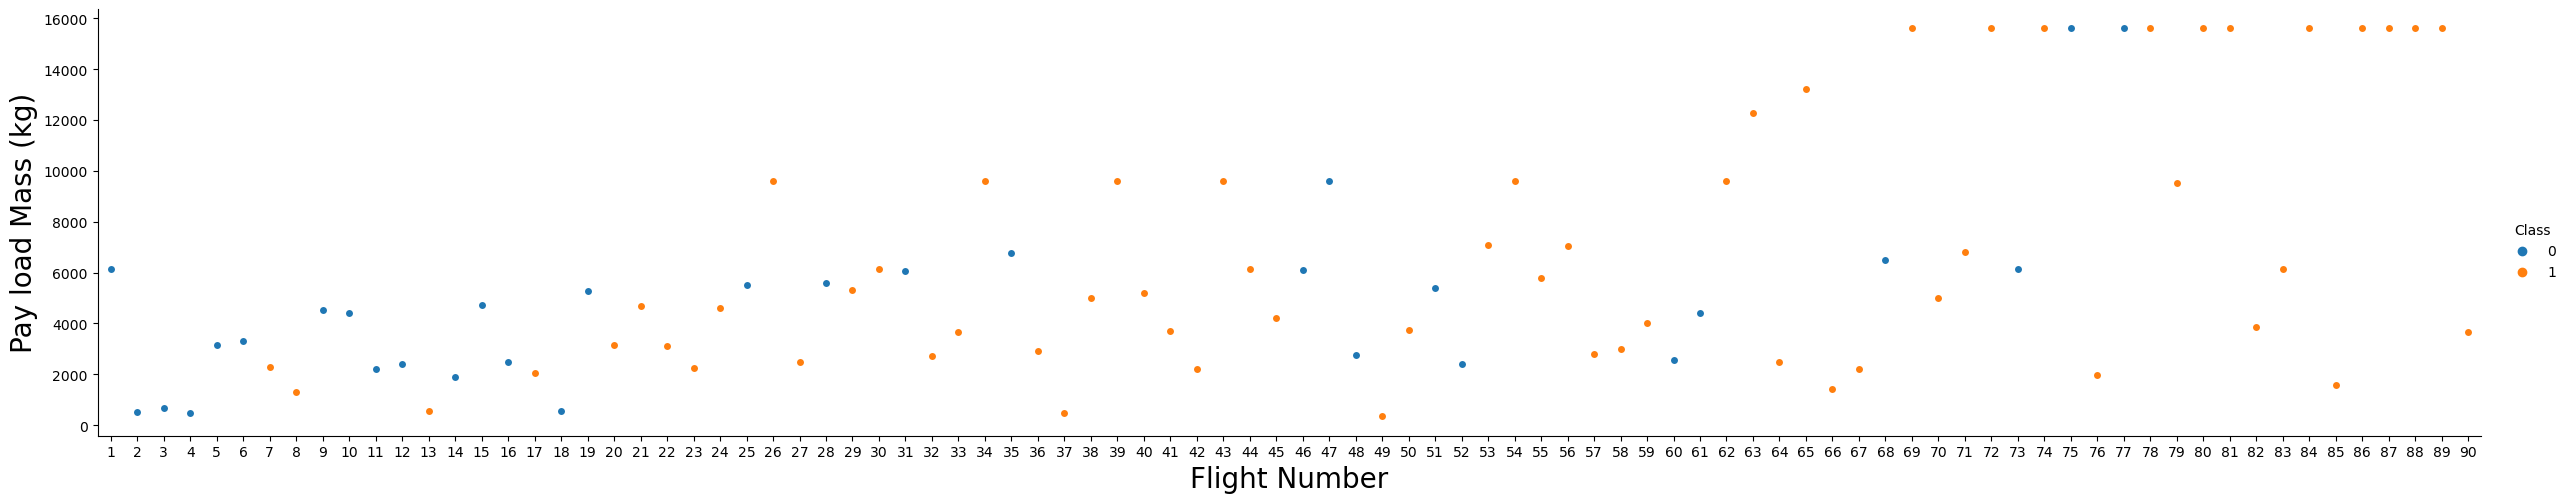

In [32]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

Next, let's drill down to each site visualize its detailed launch records.

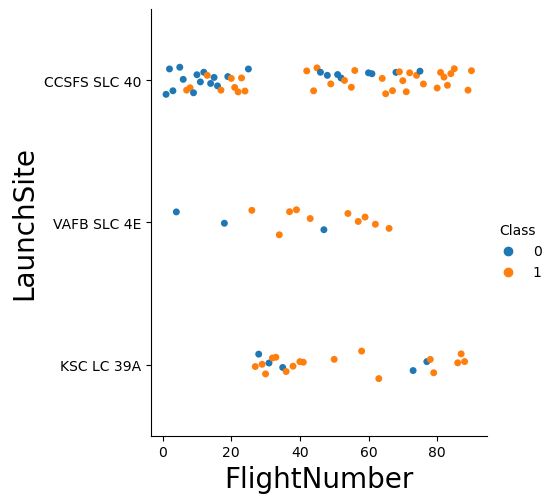

In [33]:
### Visualize the relationship between Flight Number and Launch Site
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9)
plt.ylabel("LaunchSite",fontsize=20)
plt.xlabel("FlightNumber",fontsize=20)
plt.show()

We see that different launch sites have different success rates. CCAFS LC-40, has a success rate of 60 %, while KSC LC-39A and VAFB SLC 4E has a success rate of 77%.

We also want to observe if there is any relationship between launch sites and their payload mass.

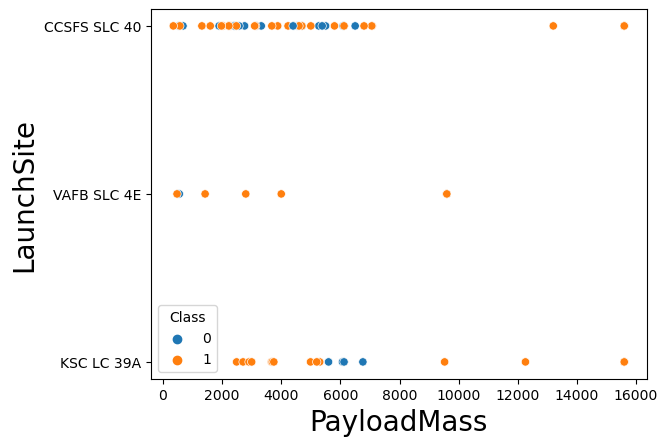

In [34]:
#Visualize the relationship between Payload and Launch Site
sns.scatterplot(y="LaunchSite", x="PayloadMass", hue="Class" , data=data_falcon9)
plt.ylabel("LaunchSite",fontsize=20)
plt.xlabel("PayloadMass",fontsize=20)
plt.show()

For the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000).

Next, we want to visually check if there are any relationship between success rate and orbit type.


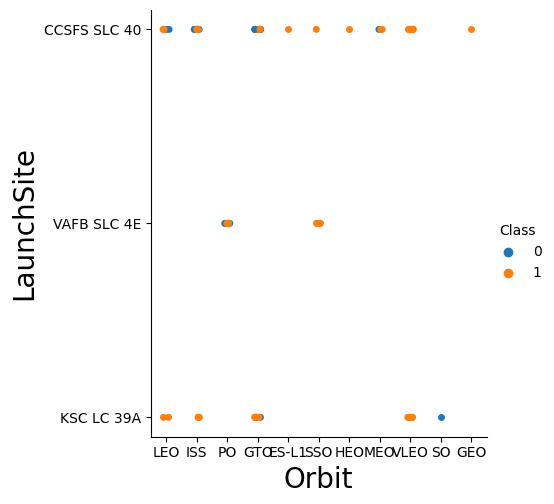

In [35]:
# Visualize the relationship between success rate of each orbit type
sns.catplot(y="LaunchSite", x="Orbit", hue="Class", data=data_falcon9)
plt.ylabel("LaunchSite",fontsize=20)
plt.xlabel("Orbit",fontsize=20)
plt.show()

Let's create a `bar chart` for the sucess rate of each orbit


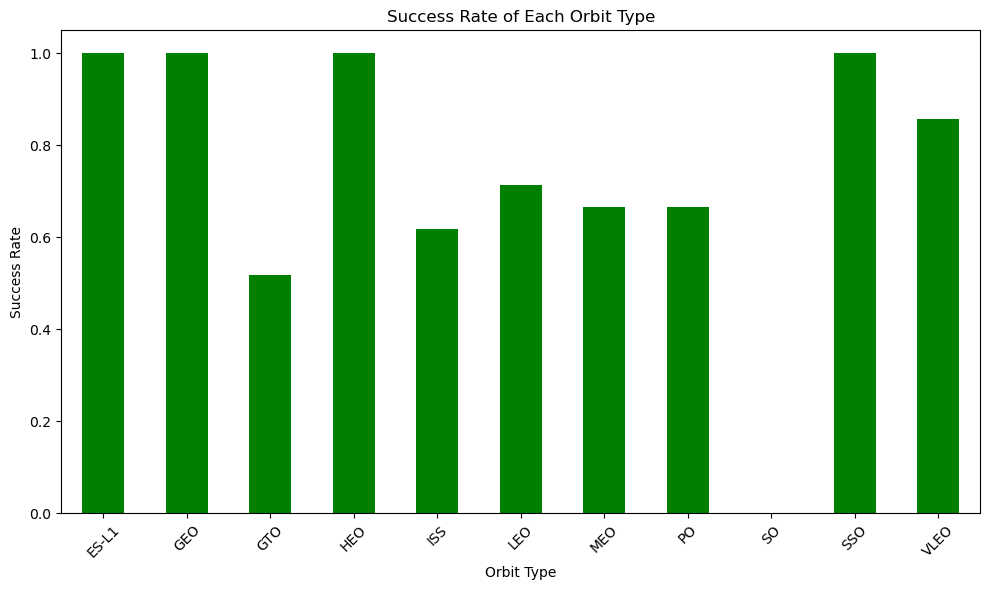

In [36]:
# Use groupby method on Orbit column and get the mean of Class column
orbit_success_rate = data_falcon9.groupby('Orbit')['Class'].mean()

# Create the bar chart
plt.figure(figsize=(10, 6))
orbit_success_rate.plot(kind='bar', color='green')
plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.title('Success Rate of Each Orbit Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Orbits ES-L-1, HEO, GEO and SSO have the maximum of success rate.

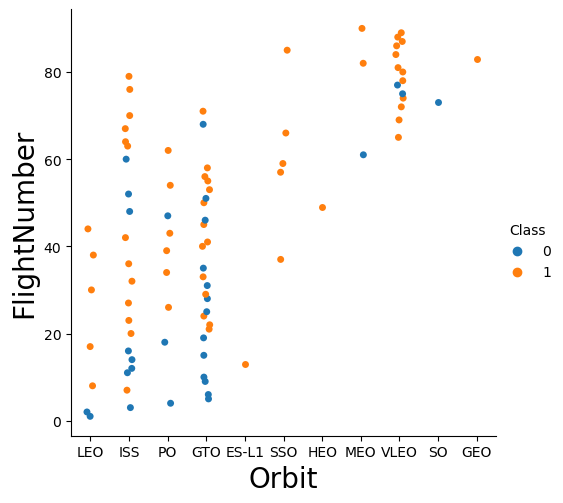

In [37]:
# Visualize the relationship between FlightNumber and Orbit type
sns.catplot(y="FlightNumber", x="Orbit", hue="Class", data=data_falcon9)
plt.ylabel("FlightNumber",fontsize=20)
plt.xlabel("Orbit",fontsize=20)
plt.show()

For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.


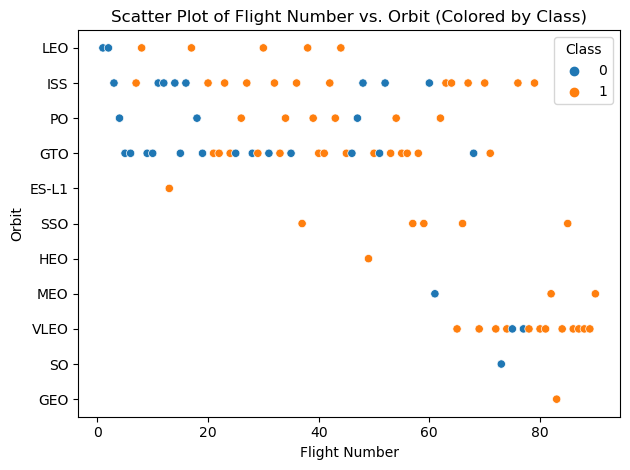

In [38]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.scatterplot(data=data_falcon9, x='FlightNumber', y='Orbit', hue='Class')
plt.xlabel('Flight Number')
plt.ylabel('Orbit')
plt.title('Scatter Plot of Flight Number vs. Orbit (Colored by Class)')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

We can see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

Similarly, we can plot the Payload vs. Orbit scatter point charts to reveal the relationship between Payload and Orbit type.


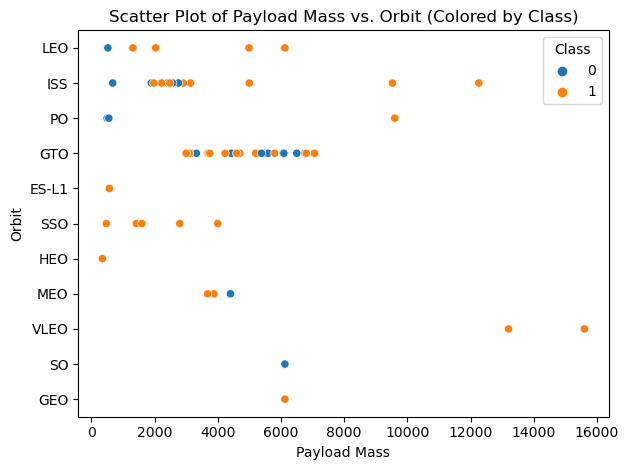

In [39]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.scatterplot(data=data_falcon9, x='PayloadMass', y='Orbit', hue='Class')
plt.xlabel('Payload Mass')
plt.ylabel('Orbit')
plt.title('Scatter Plot of Payload Mass vs. Orbit (Colored by Class)')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

# 4. Machine Learning Prediction

In this section, we will develop **machine learning** pipelines to accurately predict the landing of the first stage based on data from previous labs.
Our focus will be on utilizing **classification models**. 

The objective is to determine the unknown outcome of a launch, classifying it as either successful (1) or unsuccessful (0), using a comprehensive set of launch features.

# 4.1 Standardize and split the data

Let's first create a NumPy array from the column **Class** in data_falcon9, by applying the method to_numpy() then assign it to the variable Y:

In [40]:
Y = data_falcon9['Class'].to_numpy()
Y = pd.Series(Y)

To enhance the development of ML models, it is important to **convert object values to integer values**.

In the case of the Orbit feature, each specific **Orbit value** can be assigned an integer representation, as demonstrated below:

LEO (Low Earth Orbit) can be represented by the integer 0.

ISS (International Space Station) can be represented by the integer 1.

PO (Polar Orbit) can be represented by the integer 2.

GTO (Geostationary Transfer Orbit) can be represented by the integer 3.

ES-L1 (Earth-Sun Lagrange Point 1) can be represented by the integer 4.

SSO (Sun-Synchronous Orbit) can be represented by the integer 5.

HEO (Highly Elliptical Orbit) can be represented by the integer 6.

MEO (Medium Earth Orbit) can be represented by the integer 7.

VLEO (Very Low Earth Orbit) can be represented by the integer 8.

SO (Sub-Orbital) can be represented by the integer 9.

GEO (Geostationary Orbit) can be represented by the integer 10.

By performing this conversion, the Orbit feature will consist of corresponding integer values, allowing for more effective utilization within ML models.

Similarly, the **LaunchSite** feature will be converted from object values to integer values using the following mapping:

CCSFS SLC 40 will be represented by the integer 0.

VAFB SLC 4E will be represented by the integer 1.

KSC LC 39A will be represented by the integer 2.

By applying this conversion, the LaunchSite feature will contain corresponding integer representations, enabling seamless integration into ML models.

To simplify the notation, let's redefine the "data_falcon9" dataframe as just "**df**".






In [41]:
#redefine the "data_falcon9" dataframe as just "df
df = data_falcon9

In [42]:
# Create a dictionary mapping each unique Orbit value to an index
orbit_mapping = {orbit: index for index, orbit in enumerate(df['Orbit'].unique())}

# Replace Orbit values in the DataFrame with their corresponding integer index
df['Orbit'] = df['Orbit'].replace(orbit_mapping)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,0,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,0,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,1,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,2,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,3,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [43]:
# Create a dictionary mapping each unique LaunchSite value to an index
launch_sites = {LaunchSite: index for index, LaunchSite in enumerate(df['LaunchSite'].unique())}

# Replace LaunchSite values in the DataFrame with their corresponding integer index
df['LaunchSite'] = df['LaunchSite'].replace(launch_sites)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,0,0,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,0,0,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,1,0,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,2,1,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,3,0,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


To gather the specific features that are relevant for constructing machine learning models (PayloadMass, Orbit, Flights, LaunchSite, ReusedCount), we will collect them into a variable named **X**.

In [44]:
X = df[["PayloadMass", "Orbit","Flights", "LaunchSite", "ReusedCount"]].to_numpy()

Let's standardize the data in X, then reassign it to the variable  X using the transform provided below:


In [45]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into **training and testing data** using the function train_test_split. The training data is divided into validation data, a second set used for training data; then the models are trained and **hyperparameters** are selected using the function **GridSearchCV**.

Using the function **train_test_split**  we split the data X and Y into training and test data. Let's set the parameter **test_size to 0.2** and **random_state to 2**. The training data and test data should be assigned to the following labels:

X_train, X_test, Y_train, Y_test

In [46]:
# Split the data into training and testing sets with a test size of 0.2 (20% of the data being reserved for testing) 
# and random state of 2 (here, it is set to 2 to ensure the same train-test split is obtained when the code is run multiple times.)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [47]:
#we can see we only have 18 test samples.
Y_test.shape

(18,)

# 4.2  Logistic Regression

Let's create a **logistic regression** object then create a **GridSearchCV** object logreg_cv with cv = 10. 
Let's fit the object to find the best parameters from the dictionary parameters.

In [48]:
# Define the parameters for the logistic regression model
parameters ={'C':[0.01,0.1,1],  # The inverse of regularization strength (smaller values specify stronger regularization)
             'penalty':['l2'],  # The type of regularization penalty to be applied
             'solver':['lbfgs']}  # The solver algorithm to use for optimization

In [49]:
# Create a logistic regression model
lr=LogisticRegression()

# Create a grid search object with the logistic regression model and defined parameters
logreg_cv = GridSearchCV(lr, parameters, cv=10) # cv = 10 means 10 fold cross validations

# Fit the grid search object to the training data
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the GridSearchCV object for logistic regression. We display the best parameters using the data attribute best_params_ and the accuracy on the validation data using the data attribute best_score_.

In [50]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7517857142857143


Let's calculate the accuracy on the test data using the method score:

In [51]:
accuracy_logistic_regression = logreg_cv.score(X_test, Y_test)
print(accuracy_logistic_regression)

0.7777777777777778


Lets look at the **confusion matrix**. We first define a function  to plot it:

In [52]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

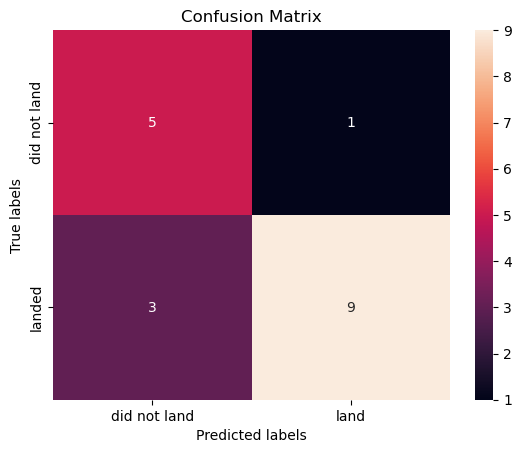

In [53]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the major problem is **false negatives** (3).

# 4.3 Suppor Vector Machine (SVM)

Let's create a **support vector machine** object then create a GridSearchCV object svm_cv with cv - 10. 

Let's fit the object to find the best parameters from the dictionary parameters.

In [54]:
# Define the parameters for the support vector machine (SVM) model
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), # The kernel function to be used
              'C': np.logspace(-3, 3, 5),                         # The regularization parameter values
              'gamma':np.logspace(-3, 3, 5)}                      # The kernel coefficient values
# Create an instance of the support vector machine (SVM) model
svm = SVC()

In [55]:
# Create a GridSearchCV object with SVM model, parameters, and cross-validation
svm_cv = GridSearchCV(svm, parameters, cv=2) # cv = 10 means 10 fold cross validations

# Fit the GridSearchCV object to the training data
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [56]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy:",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 31.622776601683793, 'kernel': 'rbf'}
accuracy: 0.7083333333333333


In [57]:
accuracy_svm = svm_cv.score(X_test, Y_test)
print(accuracy_svm)

0.8333333333333334


We can plot the confusion matrix:

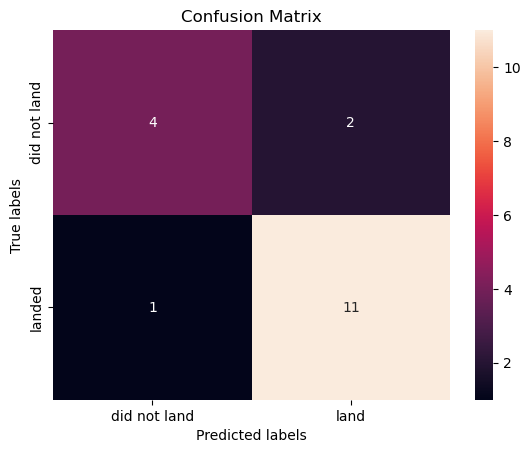

In [58]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Based on the information provided, it seems that the SVM model performs better in predicting the y values with only 1 false negative and 2 false positives.

# 4.4 Decision Tree

Let's create a decision **tree classifier** object then create a GridSearchCV object tree_cv with cv = 10. 

Let's fit the object to find the best parameters from the dictionary parameters.

In [59]:
# Define the hyperparameter grid
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

# Create a DecisionTreeClassifier object
tree = DecisionTreeClassifier()

In [60]:
# Create a GridSearchCV object with DecisionTreeClassifier model, parameters, and cross-validation
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit the GridSearchCV object to the training data
tree_cv.fit(X_train, Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/pytho

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [61]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8035714285714286


In [62]:
accuracy_decision_tree = tree_cv.score(X_test, Y_test)
print(accuracy_decision_tree)

0.7222222222222222


We can plot the confusion matrix:

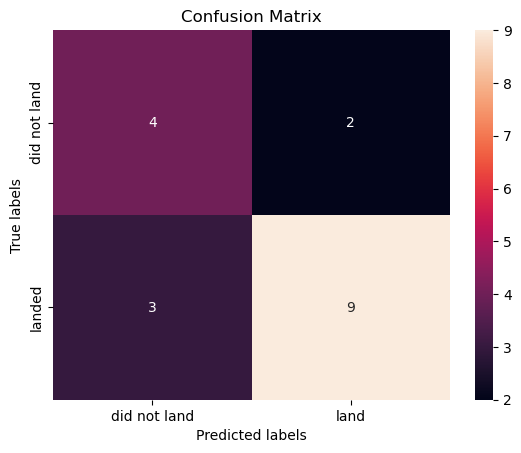

In [63]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Based on the available information, it appears that the Decision Tree model outperforms both logistic regression and SVM in terms of predictive performance. The Decision Tree model exhibits 2 false negatives and 1 false positive.

# 4.5 K-Nearest Neighbors

Let's create a **k nearest neighbors** object then create a GridSearchCV object knn_cv with cv = 10. 

Let's fit the object to find the best parameters from the dictionary parameters.

In [64]:
# Define the hyperparameter grid for KNN
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

# Create a KNeighborsClassifier object
KNN = KNeighborsClassifier()

In [65]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [66]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
accuracy : 0.7375


In [67]:
accuracy_KNN = knn_cv.score(X_test, Y_test)
print(accuracy_KNN)

0.6111111111111112


We can plot the confusion matrix:

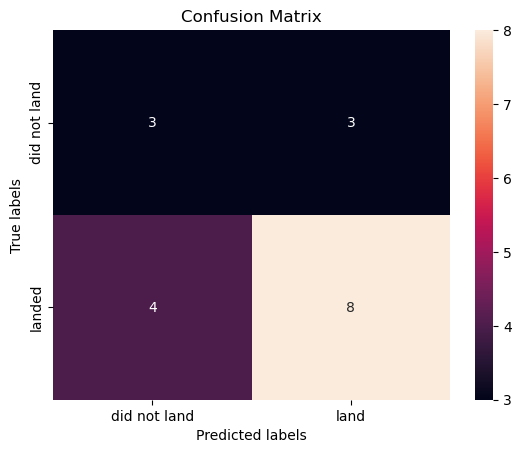

In [68]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Based on the available information, the K-Nearest Neighbors (KNN) model appears to have suboptimal predictive performance. It yields 4 false negatives and 3 false positives when predicting the y values. 

# 4.6 Comparing the Performance of Different Classification Models

Accuracy Scores:
Logistic Regression: 0.7778
Support Vector Machine: 0.8333
Decision Tree: 0.7222
K-Nearest Neighbors: 0.6111

Best Performing Model: Support Vector Machine
Accuracy: 0.8333


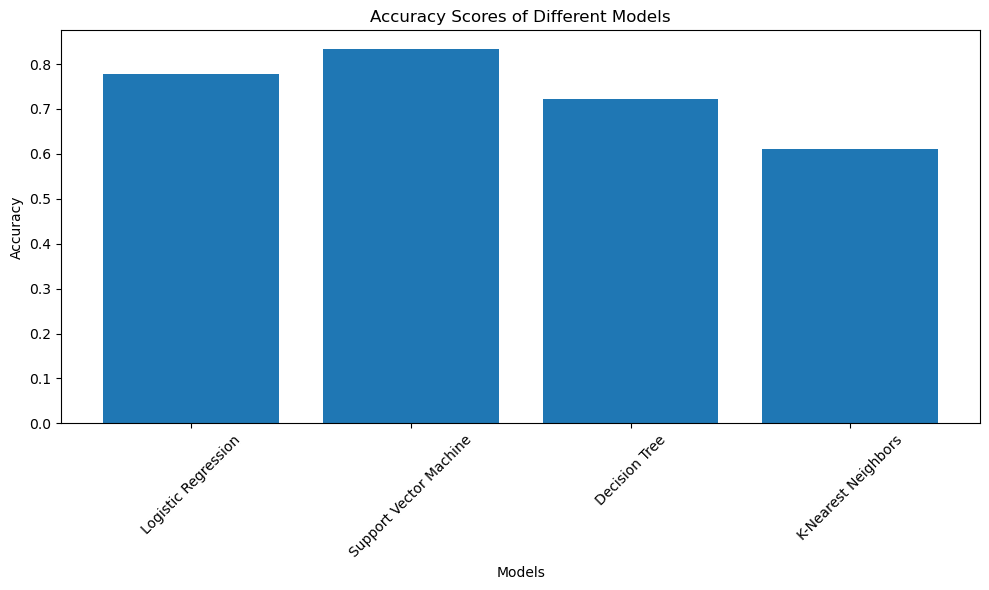

In [69]:
import matplotlib.pyplot as plt

accuracy_scores = {
    'Logistic Regression': accuracy_logistic_regression,
    'Support Vector Machine': accuracy_svm,
    'Decision Tree': accuracy_decision_tree,
    'K-Nearest Neighbors': accuracy_KNN
}

best_model = max(accuracy_scores, key=accuracy_scores.get)
best_accuracy = accuracy_scores[best_model]

# Print accuracy scores
print("Accuracy Scores:")
for model, accuracy in accuracy_scores.items():
    print(f"{model}: {accuracy:.4f}")

# Print best performing model
print(f"\nBest Performing Model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f}")

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores of Different Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From these results, it is evident that the Support Vector Machine (SVM) model and the Decision Tree model both achieved the highest accuracy score of 0.8333. On the other hand, the Logistic Regression model achieved an accuracy score of 0.7778, while the K-Nearest Neighbors (KNN) model obtained a lower accuracy score of 0.6111.

Based on these accuracy scores, the **Support Vector Machine model emerges as the best performing model** among the evaluated options, with an **accuracy of 0.8333**

Author: **Nicola Scafuri**